In [24]:
pip install relativeImp

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\user\env\matrixenv\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
# IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns

from relativeImp import relativeImp

import warnings

In [2]:
#SETTINGS
warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(15,15)})

In [3]:
#READ DATA
sample_data = pd.read_excel('data\SAMPLE_DATA.xlsx', header = 1)

In [4]:
#EXTRACT EXPLANATION 
explantion = sample_data['Variables']
sample_data = sample_data.drop(['Variables'], axis=1)

In [5]:
#TRANSPOSE DATA
transpose_sample_data = sample_data.T

In [6]:
#ADD HEADER
main_data = transpose_sample_data.rename(columns=transpose_sample_data.iloc[0]).drop(transpose_sample_data.index[0])

In [7]:
main_data.index = pd.to_datetime(main_data.index)

In [8]:
main_df = main_data.astype(float)

In [9]:
main_df['Day']= main_df.index.day
main_df['Month']= main_df.index.month
main_df['Year']= main_df.index.year
main_df['Month-Year'] = main_df[['Month', 'Year']].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)

In [10]:
main_df.head(5)

,BRAND_A_VOLUME,BRAND_A_PRICE,COMPETITOR_A_PRICE,COMPETITOR_B_PRICE,COMPETITOR_C_PRICE,COMPETITOR_D_PRICE,COMPETITOR_E_PRICE,BRAND_A_New product,COMPETITOR_New product,BRAND_A_Insert,...,COMPETITOR_D_TOTAL_GRP,COMPETITOR_E_TOTAL_GRP,COMPETITOR_F_TOTAL_GRP,Real_Private_Consumption,BRAND_A_NDP,Teshir_Orani_BRAND_A,Day,Month,Year,Month-Year
2016-05-02,35232.8,12.593379,11.89,15.37,13.35,11.74,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,964.074,0.0,0.0,2,5,2016,5-2016
2016-05-09,155680.4,9.306888,9.51,9.65,9.94,8.36,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,964.074,0.0,0.0,9,5,2016,5-2016
2016-05-16,34356.6,12.539075,12.14,15.17,13.04,11.60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,964.074,0.0,0.0,16,5,2016,5-2016
2016-05-23,34145.7,12.915243,12.69,15.61,13.49,11.61,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,964.074,0.0,0.0,23,5,2016,5-2016
2016-05-30,35328.5,12.678149,12.31,15.47,13.67,12.17,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,964.074,0.0,0.0,30,5,2016,5-2016


### Correlation HeatMap

Pearson’s correlation coefficient is the test statistics that measures the statistical relationship, or association, between two continuous variables.  It is known as the best method of measuring the association between variables of interest because it is based on the method of covariance.  It gives information about the magnitude of the association, or correlation, as well as the direction of the relationship.

In [11]:
corr = main_df.corr()

<AxesSubplot:>

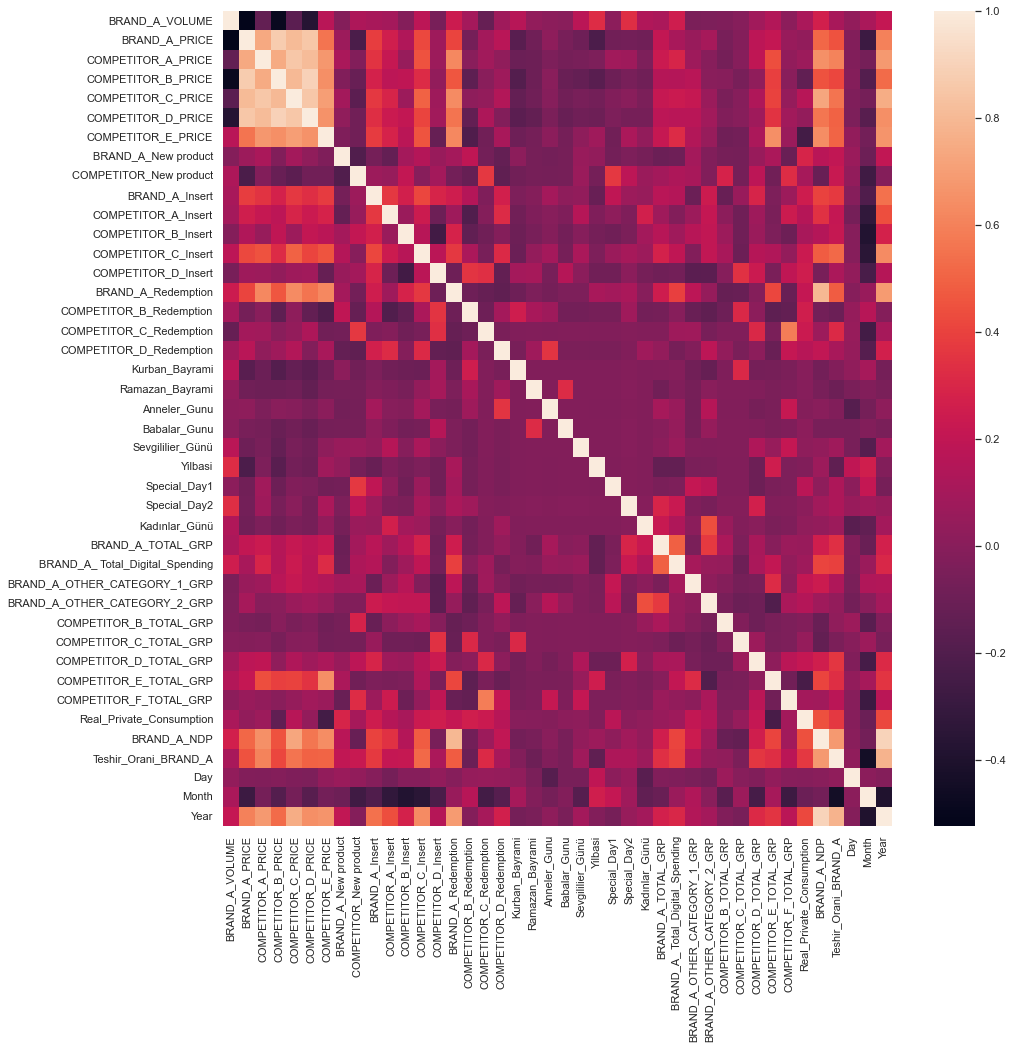

In [12]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

### Key-Driver Analysis

Key Driver Analysis is a methodology branded in market research, called Relative Weights Analysis in Data Science (which can be either Shapley or Johnson's method). Key Drivers Analysis identifies how much each of the predictor variables (the drivers) are moving the depentor variable (key metric, key performance indicator aka KPI). In other words, "what are the drivers of your key metric?"

Relative importance or relative weight analysis is a method to “partition explained variance among multiple predictors to better understand the role played by each predictor in a regression equation” [(Tonidandel & LeBreton, 2011)](https://www.scotttonidandel.com/rwa-web). 

In [16]:
yName =  'BRAND_A_VOLUME'

xNames = ['BRAND_A_PRICE', 'COMPETITOR_A_PRICE', 'COMPETITOR_B_PRICE',
       'COMPETITOR_C_PRICE', 'COMPETITOR_D_PRICE', 'COMPETITOR_E_PRICE',
       'BRAND_A_New product', 'COMPETITOR_New product', 'BRAND_A_Insert',
       'COMPETITOR_A_Insert', 'COMPETITOR_B_Insert',
       'COMPETITOR_C_Insert', 'COMPETITOR_D_Insert', 'BRAND_A_Redemption',
       'COMPETITOR_B_Redemption', 'COMPETITOR_C_Redemption',
       'COMPETITOR_D_Redemption', 'Kurban_Bayrami', 'Ramazan_Bayrami',
       'Anneler_Gunu', 'Babalar_Gunu', 'Sevgililier_Günü', 'Yilbasi',
       'Special_Day1', 'Special_Day2', 'Kadınlar_Günü',
       'BRAND_A_TOTAL_GRP', 'BRAND_A_ Total_Digital_Spending',
       'BRAND_A_OTHER_CATEGORY_1_GRP', 'BRAND_A_OTHER_CATEGORY_2_GRP',
       'COMPETITOR_B_TOTAL_GRP', 'COMPETITOR_C_TOTAL_GRP',
       'COMPETITOR_D_TOTAL_GRP', 'COMPETITOR_E_TOTAL_GRP',
       'COMPETITOR_F_TOTAL_GRP', 'Real_Private_Consumption',
       'BRAND_A_NDP', 'Teshir_Orani_BRAND_A']

results = relativeImp(main_df, outcomeName = yName, driverNames = xNames)
sorted_result = results.sort_values(by=['rawRelaImpt','normRelaImpt'],ascending=False)
sorted_result

,driver,rawRelaImpt,normRelaImpt
0,BRAND_A_PRICE,0.151319,17.055119
2,COMPETITOR_B_PRICE,0.116164,13.092788
4,COMPETITOR_D_PRICE,0.076695,8.644255
3,COMPETITOR_C_PRICE,0.049528,5.582263
13,BRAND_A_Redemption,0.049301,5.556718
36,BRAND_A_NDP,0.047541,5.358399
22,Yilbasi,0.047528,5.356926
24,Special_Day2,0.044598,5.026588
5,COMPETITOR_E_PRICE,0.041939,4.726898
1,COMPETITOR_A_PRICE,0.039838,4.490113


In [17]:
sum(results.rawRelaImpt) # R-squared

# What is a good R-squared?
# <.3 is not good
# .3 - .4 is normal
# .4 - .5 is great
# .5 - .6 is exceptional
# >.6 is dangerously high, possibly overfitting

0.8872328754030646

In [18]:
print('Key Sales Drivers:')
print(sorted_result[:6].driver)

Key Sales Drivers:
0          BRAND_A_PRICE
2     COMPETITOR_B_PRICE
4     COMPETITOR_D_PRICE
3     COMPETITOR_C_PRICE
13    BRAND_A_Redemption
36           BRAND_A_NDP
Name: driver, dtype: object


## Price Elasticity

In [ ]:
sns.set(rc={'figure.figsize':(25,15)})
main_df.groupby(by=['Month-Year'])[['BRAND_A_PRICE', 'COMPETITOR_A_PRICE', 'COMPETITOR_B_PRICE', 'COMPETITOR_D_PRICE']].mean().plot()

In [ ]:
main_df[['BRAND_A_PRICE', 'COMPETITOR_A_PRICE', 'COMPETITOR_B_PRICE',
       'COMPETITOR_C_PRICE', 'COMPETITOR_D_PRICE']].plot()

In [ ]:
main_df['Quantity'] = main_df['BRAND_A_VOLUME'] / main_df['BRAND_A_PRICE']

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
main_df.plot.scatter(x='Quantity',y='BRAND_A_PRICE')

In [ ]:
sns.pairplot(main_df,kind='reg',height=8,x_vars=['BRAND_A_PRICE'],y_vars=['Quantity'])

In [ ]:
import statsmodels.api as sm
endog = main_df['Quantity']
exog = sm.add_constant(main_df['BRAND_A_PRICE'])
mod = sm.RecursiveLS(endog, exog)
res = mod.fit()
print(res.summary())